In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path

from Utils.api_ipc_request import construct_ipc_api_url
from Utils.api_boundary_request import construct_boundary_api_url
from Utils.temporal_coverage import plot_fewsnet_scenario_coverage
from Utils.countries_to_process import select_country_codes
from Utils.check_shapefile import pg_shapefile_exists
from Utils.input_base_requirements import get_date_range, select_ipc_classification

# Feature Engineering
from Utils.filter_tables import desirable_attributes
from Utils.merge_and_report import merge_ipc_with_boundaries, evaluate_merge_completness
from Utils.scenario import define_scenario

# Plot
from Utils.plot_ipc_orig_boundaries import plot_historical_ipc

# Load PG
from Utils.give_PG_reference import provide_reference_frame


#Compute area features
from Utils.area_attributes import define_area_attributes


#Perform Intersection
from Utils.perform_intersection import intersect
from Utils.build_envelope import envelope_buffer


#Define process to conver FEWSNET to PG
from Utils.select_process import define_process
from Utils.user_process_selection import get_process_selection


#Rejoin data to PG shapefile (GPD)
from Utils.rejoin_pg_data import rejoin_to_pg

from Utils.cumulative_population_attribution import engineer_population_attributes
from Utils.pg_country_extent import create_country_geodataframe
from Utils.leftjoin_to_pg_country import left_join_geodataframes
from Utils.select_dates import get_dates_to_process

# Save the data
from Utils.csv_naming_conventions import apply_naming_convention

## To Do:

#### For process 6:

1. Would you like to define specific population thresholds?
If not, the default thresholds (50, 85 percentiles) will be used.

- Define why and how this effects the process as a print() statement

2. For the 90th percentile:
Enter the population weight for the 90th percentile (e.g., 1.0): 1.0
Enter the area weight for the 90th percentile (e.g., 0.0): 0.0

- make sure that the two weights equal 1.0
- if they do not equal 1.0 provide the user the opportunity to re-enter input values for both elements (restart this procedure / prompt)

3. Loading shapefile from: /Users/gbenz/Documents/FEWSnet/Data/Processed/extent_shapefile/pg_viewser_extent.shp
- print a line on what is happening, or ommit this print statement
- I suspect this is referencing `result_gdf = rejoin_to_pg(result)` 
- but it may also be: `gpd_country_extent_df = create_country_geodataframe(country_name, year_int, shapefile_path=None)` 



In [3]:
#project_root = Path(__file__).resolve()

# Designate a local path:
csv_path = '/Users/gbenz/Documents/FEWSnet/Data/Processed/csv/FEWSnet_to_PG_'
print(f'The final csv result will be saved to path: {csv_path}')

The final csv result will be saved to path: /Users/gbenz/Documents/FEWSnet/Data/Processed/csv/FEWSnet_to_PG_


### Process to define historical data for ingestion

The PG reference shapefile has already been produced!
Type 'q' at any time to quit the process.

General date ranges associated with each IPC classification:
1. IPC 2.0: ~2004–2012
2. IPC 3.0: ~2013–2018
3. IPC 3.1: ~2019–Present

Please choose an IPC classification from the options above.
Selected IPC classification: IPC 3.1 (IPC31)
Please supply a start date in the YYYY-MM-DD format (e.g., 2004-01-01):
Your selected start date is: 2020-01-01
Please supply an end date in the YYYY-MM-DD format (e.g., 2012-12-31):
Your selected end date is: 2024-12-31
The API call constructed: https://fdw.fews.net/api/ipcphase.csv?start_date=2020-01-01&end_date=2024-12-31&classification_scale=IPC31

Data downloaded and saved as ipc_data.csv to folder Data/Generated/ipc_data.csv

['source_organization', 'source_document', 'country', 'country_code', 'geographic_group', 'fewsnet_region', 'geographic_unit_full_name', 'geographic_unit_name', 'unit_type', 'fnid', 'classification_scale', 'scenario_name', 'pref

100%|██████████| 40.0M/40.0M [00:02<00:00, 14.8MB/s]


Queryset Fatalities_fao_pgm read successfully 


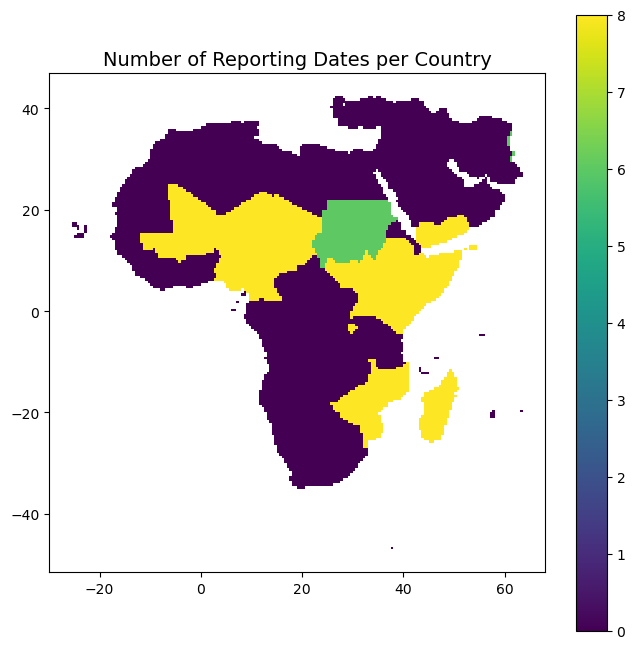


Process Selection Options:

1: - First checks for rows meeting both a proportional area threshold and a critical value.
  - Assigns the maximum value from the filtered rows if conditions are met.
  - Otherwise, calculates a fallback weighted sum of values by proportional area.

2: - Assigns the value that occupies the largest proportion of area within each `pg_id`.
  - Uses the row with the highest `Proportional_area` as the dominant value.

3: - Multiplies each row’s value by its proportional area to compute a weighted value.
  - Groups data by `pg_id` and sums the weighted values to produce a dissolved value.

4: - Assigns the maximum value if its proportional area exceeds a specified threshold.
  - If no rows meet the threshold, calculates a fallback weighted sum of values by proportional area.

5: - Uses the row with the greatest population proportion within each `pg_id`.
  - Combines population and area proportions to calculate weighted values, summing these at the `pg_id` level.

KeyboardInterrupt: Interrupted by user

In [4]:


if pg_shapefile_exists():
    print("The PG reference shapefile has already been produced!")
else:
    print(
    "The PG Shapefile does not exist. This process must be completed before integrating FEWSNET data.\n"
    "I will produce and save the PG reference file now. Once complete, it can be accessed in Data/Processed/extent_shapefile/"
    )
    
    provide_reference_frame()

ipc_classification = select_ipc_classification()
s, e = get_date_range()
ipc = construct_ipc_api_url(s, e, ipc_classification)
print(list(ipc))
#Print all country_codes:
#country_code_list = sorted(ipc['country_code'].unique().tolist())

ipc_country, selected_country_codes = select_country_codes(ipc)

endyear = int(e.split('-')[0])

icp_country_result = plot_fewsnet_scenario_coverage(ipc, endyear)

process_selection = get_process_selection()

all_country_results = []

for country_code in selected_country_codes:

    # identify country associated with country code:

    country_name = ipc.loc[ipc['country_code'] == country_code, 'country'].iloc[0]

    print(f"Processing country: {country_code} ({country_name})")

    boundaries = construct_boundary_api_url(country_code)

    ipc_filtered, spatial_filtered = desirable_attributes(ipc_country, boundaries)

    merge, unmatched = merge_ipc_with_boundaries(ipc_filtered, spatial_filtered)

    evaluate_merge_completness(merge, ipc_filtered, unmatched)

    scenario = define_scenario(merge)

    merged_df_current = gpd.GeoDataFrame(scenario, geometry='geometry')

    plot_historical_ipc(merged_df_current)

    result_dfs = []

    # Get unique dates from the dataset
    dataset_dates = sorted(merged_df_current['reporting_date'].unique().tolist())
    print(dataset_dates)

    dates_to_process = get_dates_to_process(dataset_dates)

    # Loop through each date in the dataset_dates
    for i, processing_date in enumerate(dates_to_process):  # Enumerate gives both index and value
        print()
        print(f"Processing date: {processing_date}")
        print()

        # Extract the year from the current processing date
        year = processing_date.split('-')[0]
        year_int = int(processing_date.split('-')[0])

        # Filter the dataset for the current date
        merged_df_current_lim = merged_df_current[merged_df_current['reporting_date'] == processing_date]

        # Generate a buffered envelope for the filtered dataset
        envelope_gdf_buffered = envelope_buffer(merged_df_current_lim, distance=25000)

        # Ensure only valid geometry types
        merged_df_current_lim = merged_df_current_lim[merged_df_current_lim.geom_type.isin(['Polygon', 'MultiPolygon'])]

        # Perform the intersection
        intersected_gdf = intersect(merged_df_current_lim)

        # Ensure area attributes are defined
        intersected_gdf = define_area_attributes(intersected_gdf)

        # Check if the selected process requires population data
        if process_selection in [5, 6]:
            intersected_gdf = engineer_population_attributes(year, country_code, intersected_gdf, envelope_gdf_buffered)

        # Define the process and generate the result
        result = define_process(process_selection, intersected_gdf)

        # Rejoin the result to the priogrid
        # Applies the data frame containing a pg attribute to the spatial pg extent
        result_gdf = rejoin_to_pg(result)
        
        # Add processing_date and country_code fields to result_gdf
        result_gdf['processing_date'] = processing_date
        result_gdf['country_code'] = country_code

        # Trim results to PG (viewser defined) country extent
        gpd_country_extent_df = create_country_geodataframe(country_name, year_int, shapefile_path=None)
        
        print()
        print('Fields in DF2')
        print(list(result_gdf))
        print()
        print('Fields in DF1')
        print(list(gpd_country_extent_df))
        print()

        country_joined=left_join_geodataframes(gpd_country_extent_df, result_gdf)

        # Append the result_gdf to the list
        result_dfs.append(country_joined)

        print(f"Completed processing for {processing_date}. Result saved.")

    # Concatenate the results for the current country
    country_result_df = pd.concat(result_dfs, ignore_index=True)

    # Check if 'final_weighted_value' exists before renaming
    if 'final_weighted_value' in country_result_df.columns:
        country_result_df = country_result_df.rename(columns={'final_weighted_value': 'IPC_value'})

    # Check if 'original_sum_value' exists before dropping
    if 'original_sum_value' in country_result_df.columns:
        country_result_df = country_result_df.drop(columns=['original_sum_value'])

    # Append to the all-country results list
    all_country_results.append(country_result_df)

# Concatenate results for all countries
final_result_df = pd.concat(all_country_results, ignore_index=True)

# Naming Conventions:
naming_conventions = apply_naming_convention(dates_to_process, selected_country_codes, process_selection)

csv_path_with_naming = csv_path.with_name(csv_path.name + naming_conventions + '.csv')

# The final_result_df now contains data for all countries and dates
final_result_df.to_csv(csv_path_with_naming)

In [ ]:
country_name

In [ ]:
from Utils.pg_country_extent import create_country_geodataframe

country_name = 'Ethiopia'
year = 2022

gpd_df = create_country_geodataframe(country_name, year, shapefile_path=None)


## To Do:

4. Trim to Country PG extent 
4. provide a name, informed by the parameters, to ingest into viewser


In [ ]:
from viewser import Queryset, Column
import pandas as pd

from ingester3.extensions import *

def give_primary_frame(queryset_name, cm_queryset, start, end):

    """"
    1. retrieves base queryset
    2.assigns a year field from Ingester3 functions
    3. trims to defined intervals
    4. sum fatalities

    """

#Here is the queryset used:
    
    # (Queryset('Fatalities_fao_pgm','priogrid_month')
    # .with_column(Column('country_name', from_loa='country', from_column='name')
    #     )

    # .with_column(Column('C_start_year', from_loa='country', from_column='gwsyear')
    #     )

    # .with_column(Column('C_end_year', from_loa='country', from_column='gweyear')
    #     )

    # .with_column(Column('pop_gpw_sum', from_loa='priogrid_year', from_column='pop_gpw_sum')
    #     )

    # .with_column(Column('ged_sb', from_loa='priogrid_month', from_column='ged_sb_best_sum_nokgi')
    #     .transform.missing.replace_na()
    #     )

    # .with_column(Column('ged_ns', from_loa='priogrid_month', from_column='ged_ns_best_sum_nokgi')
    #     .transform.missing.replace_na()
    #     )

    # .with_column(Column('ged_os', from_loa='priogrid_month', from_column='ged_os_best_sum_nokgi')
    #     .transform.missing.replace_na()
    #     )

    # )

    queryset_base_PG= (Queryset(queryset_name, ''))
    df = queryset_base_PG.fetch()
    df = df.reset_index()

    queryset_cm= (Queryset(cm_queryset, ''))
    cm_properties = queryset_cm.fetch()
    cm_properties = cm_properties.reset_index()    

    df['year'] = df.m.year

    df_trimmed = df[(df['year'] > start) & (df['year'] < end)]
    df_trimmed['fatalities_sum'] = df_trimmed['ged_sb'] + df_trimmed['ged_ns'] + df_trimmed['ged_os']


    merged_cid = pd.merge(df_trimmed, cm_properties[['month_id', 'country_name', 'country_id']], on=['month_id', 'country_name'], how='left')
    #print(merged_cid)
    df_pg = merged_cid

    df_pg = df_pg.rename(columns={'priogrid_gid':'pg_id'})
    #df_pg['year_id'] = df_pg['month_id'].apply(views_month_id_to_year)

    print(list(df_pg))
    return(df_pg)

## To Do:

Clip processessing to the extent defined in viewser system 

1. Get country name from the country code selection earlier
2. apply current year parameter


parameters:
- pcd dataframe (this should be constructed with an option parameter to designate a speicifc destination)
- year 
- country name

In [ ]:
import pandas as pd
import geopandas as pgd 
from ingester3.extensions import *

gpd_df = gpd.read_file('Data/Processed/extent_shapefile/pg_viewser_extent.shp')




new_country_year = pd.DataFrame.cy.new_africa(max_year=2020) # year + 1
new_country_year['name'] = new_country_year.c.name
print(new_country_year)

countries = sorted(pd.unique(new_country_year['name'].tolist()))
print(countries)


filtered_df = new_country_year[(new_country_year['name'] == 'Ethiopia') & (new_country_year['year_id'] == 2020)]
print(filtered_df)

filtered_df_pg=filtered_df.cy.pg_id

print(list(filtered_df_pg))

merged_df = pd.merge(filtered_df_pg, gpd_df, on='pg_id', how='inner')  # Default join is inner
print(list(merged_df))


# Assuming `df` is your DataFrame
if 'geometry' in merged_df.columns:
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(merged_df, geometry=merged_df['geometry'])

    # Ensure CRS is set
    if gdf.crs is None:
        gdf.set_crs("EPSG:4326", inplace=True)  # Assuming WGS84 CRS (latitude/longitude)

    print("Conversion to GeoDataFrame successful!")
    print(gdf.head())  # Display the first few rows
else:
    print("Error: 'geometry' column not found in the DataFrame.")


In [ ]:
merged_df

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your GeoDataFrame
gdf.plot(
    edgecolor='black',  # Set edge color to black
    linewidth=0.5,      # Set line width for grid edges
    facecolor='none',   # Make polygons transparent
    figsize=(10, 6)     # Adjust figure size
)

# Customize the plot
plt.title("Polygon Grids", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
# Look how easy it is to convert a CY dataframe in a PGY dataframe
gpd['c_id'] = gpd.pgy.c_id

c_d.cy.pg_id
gpd

In [ ]:

import pandas as pd
from ingester3 import *
df_with_cid = pd.DataFrame.c.from_pg(intersected_gdf, pg_col='pg_id')
